## Apply noise-diode-based gain corrections to azimuth and raster scans
### A. Ordog, July 2022
### NOTE: please do not modify
#### July 12, 2022: updated to include RR gains, set outlier threshold based on stdev, write out new files with all 4 products corrected
#### July 18, 2022: modified to use polynomial fit to gain vs time rather than interpolation
#### Oct 5, 2022: modified to record corrected scans in noise source units
#### Oct 26, 2022: changed noise source outlier thresholding, added possibility of multiple evening/morning raster scans
#### Nov 22, 2022: corrected 'off' source calculation to not just use endpoints on either side of interval

In [24]:
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from scipy import interpolate
from operator import itemgetter
from itertools import groupby
from astropy.convolution import convolve, Box1DKernel
import gc

phase = '1'
day ='21'
trim_rast_exist = False
trim_az_exist = True
Nm = 1 # number of morning raster scans
Ne = 1 # number of evening raster scans

#### Change the directory to where the files are located" ####
#dir_in = '/media/ordoga/DVA_data/survey_phase1_day'+day+'/'
#dir_out = '/media/ordoga/DVA_data/survey_phase1_day'+day+'/'
##############################################################

### Use these directories on elephant: ###################
dir_in_rast  = '/srv/data/dva/survey_raster/'
dir_out_rast = '/srv/data/dva/survey_raster_noise_corr/'
dir_in_az    = '/srv/data/dva/survey_azimuth_scans/'
dir_out_az    = '/srv/data/dva/survey_azimuth_scans_noise_corr/'
###########################################################

## Read in files listing start and stop times for azimuth and raster scans:

In [25]:
scan_id = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

raster1_start = []
raster2_start = []
raster1_stop = []
raster2_stop = []

rast_list = ['a','b','c']

# Read in the azimuth scan data and store it in arrays:
with open(dir_in_az+'DVAsurvey_phase'+phase+'_day0'+day+'.txt') as fp:
    for line in fp:       
        scan_id.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])
              
for i in range(0,Ne):
    
    if Ne == 1:
        rast1name = 'dva_survey_phase'+phase+'_day0'+day+'_raster1.txt'
    else:
        rast1name = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.txt'
        
    with open(dir_in_rast+rast1name) as fp:
        for line in fp:  
            raster1_start.append(line.split()[3])
            raster1_stop.append(line.split()[4])
            
for i in range(0,Nm):
    
    if Nm == 1:
        rast2name = 'dva_survey_phase'+phase+'_day0'+day+'_raster2.txt'
    else:
        rast2name = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.txt'
        
    with open(dir_in_rast+rast2name) as fp:
        for line in fp:  
            raster2_start.append(line.split()[3])
            raster2_stop.append(line.split()[4])
                
print('raster 1:',raster1_start,raster1_stop)
print('')
for i in range(0,len(scan_id)):
    print(f"{scan_id[i]:04}",scan_start[i],scan_stop[i])
print('')
print('raster 2:',raster2_start,raster2_stop)

# Convert start and stop times to Modified Julian Day (MJD).
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd
raster1_start_mjd = Time(raster1_start, format='isot',scale='utc').mjd
raster1_stop_mjd  = Time(raster1_stop,  format='isot',scale='utc').mjd
raster2_start_mjd = Time(raster2_start, format='isot',scale='utc').mjd
raster2_stop_mjd  = Time(raster2_stop,  format='isot',scale='utc').mjd

raster 1: ['2022-06-30T02:40:02.316993'] ['2022-06-30T03:37:07.839786']

2491 2022-06-30T03:54:28.153 2022-06-30T04:12:30.329
2492 2022-06-30T04:14:12.932 2022-06-30T04:32:15.053
1197 2022-06-30T04:37:33.211 2022-06-30T04:55:35.319
1198 2022-06-30T04:57:18.001 2022-06-30T05:15:20.323
1199 2022-06-30T05:17:38.664 2022-06-30T05:35:41.006
2712 2022-06-30T05:40:22.475 2022-06-30T05:58:24.550
1417 2022-06-30T06:03:06.860 2022-06-30T06:21:09.224
1418 2022-06-30T06:23:27.746 2022-06-30T06:41:29.518
1493 2022-06-30T06:46:11.995 2022-06-30T07:04:13.791
1494 2022-06-30T07:05:56.687 2022-06-30T07:23:58.984
1495 2022-06-30T07:25:41.527 2022-06-30T07:43:43.927
1496 2022-06-30T07:46:02.123 2022-06-30T08:04:03.981
1497 2022-06-30T08:05:47.068 2022-06-30T08:23:48.912
1498 2022-06-30T08:25:31.642 2022-06-30T08:43:33.545
0203 2022-06-30T08:48:51.641 2022-06-30T09:06:53.689
1716 2022-06-30T09:11:36.149 2022-06-30T09:29:38.011
1717 2022-06-30T09:31:20.914 2022-06-30T09:49:22.944
1718 2022-06-30T09:51:41.1

## Read in data and stitch together

In [26]:
def concatenate_data(file,RR,LL,reRL,imRL,dec,ra,el,az,t,noise):
    
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    idx1 = len(t)
    
    # Add the position and time data to the corresponding arrays:
    dec = np.concatenate([dec,dataset['metadata']['declination']])
    ra = np.concatenate([ra,dataset['metadata']['right_ascension']])
    el = np.concatenate([el,dataset['metadata']['elevation']])
    az = np.concatenate([az,dataset['metadata']['azimuth']])
    t = np.concatenate([t,dataset['metadata']['utc']])
    noise = np.concatenate([noise,dataset['metadata']['noise_state']])

    idx2 = len(t)
    
    # Add the spectrometer power data to the corresponding arrays:
    RR = np.concatenate([RR,dataset['data'][:,0,:]],axis=0)
    LL = np.concatenate([LL,dataset['data'][:,1,:]],axis=0)
    reRL = np.concatenate([reRL,dataset['data'][:,2,:]],axis=0)
    imRL = np.concatenate([imRL,dataset['data'][:,3,:]],axis=0)
    
    return RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2

In [32]:
%%time

t = []
az = []
dec = []
ra = []
el = []
noise = []
idx1_rast1 = []
idx2_rast1 = []
idx1_rast2 = []
idx2_rast2 = []

# Use one of the scans to get the list of frequencies:
scan0 = f"{scan_id[0]:04}"
file = h5py.File(dir_in_az+'dva_survey_phase'+phase+'_raw_'+scan0+'.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6

# Create empty arrays for the power data:
RR = np.empty([0,len(freq)])
LL = np.empty([0,len(freq)])
reRL = np.empty([0,len(freq)])
imRL = np.empty([0,len(freq)])

# Raster scan 1:
for i in range(0,Ne):
    if Ne == 1:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'.h5','r')
    else:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.h5','r')

    rast1_file_t = [Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                        format='isot',scale='utc').mjd,
                    Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                        format='isot',scale='utc').mjd]
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    idx1_rast1.append(idx1)
    idx2_rast1.append(idx2)

# Loop through all the scans in the "scan_num" list:
for i in scan_id:
    file = h5py.File(dir_in_az+'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'.h5','r')
    print(i,file)
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    
# Raster scan 2:
for i in range(0,Nm):
    if Nm == 1:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'.h5','r')
    else:
        file = h5py.File(dir_in_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.h5','r')

    rast2_file_t = [Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                        format='isot',scale='utc').mjd,
                    Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                        format='isot',scale='utc').mjd]
    RR,LL,reRL,imRL,dec,ra,el,az,t,noise,idx1,idx2 = concatenate_data(file,RR,LL,reRL,imRL,
                                                            dec,ra,el,az,t,noise)
    print(idx1,idx2)
    idx1_rast2.append(idx1)
    idx2_rast2.append(idx2)

t_set_plt = Time(t, format='isot',scale='utc').mjd

print(RR.shape)
print(t_set_plt.shape)

KeyboardInterrupt: 

In [28]:
print(rast1_file_t)
print(idx1_rast1)
print(idx2_rast1)
print('')
print(rast2_file_t)
print(idx1_rast2)
print(idx2_rast2)
print('')
print(t_set_plt)
t_mean = np.nanmean(t_set_plt)
print(t_mean)

[59760.11062500001, 59760.15228472224]
[]
[]

[59759.5022569445, 59759.5466944445]
[]
[]

[59759.10434028 59759.10434722 59759.10435417 ... 59759.54668056
 59759.5466875  59759.54669444]
59759.32992716642


## Read in temperature data

In [29]:
def month_to_num(month_name):
    if month_name == 'Jan': month_num = '01'
    if month_name == 'Feb': month_num = '02'
    if month_name == 'Mar': month_num = '03'
    if month_name == 'Apr': month_num = '04'
    if month_name == 'May': month_num = '05'
    if month_name == 'Jun': month_num = '06'
    if month_name == 'Jul': month_num = '07'
    if month_name == 'Aug': month_num = '08'
    if month_name == 'Sep': month_num = '09'
    if month_name == 'Oct': month_num = '10'
    if month_name == 'Nov': month_num = '11'
    if month_name == 'Dec': month_num = '12'
    return(month_num)

i = 0
t_weath = []
temp_C = []

with open('/srv/data/dva/weather_data/weather_survey_phase'+phase+'.txt') as fp:
    for line in fp:
        t_weath.append(str( line.split()[2]+'-'+month_to_num(line.split()[1])+'-'+line.split()[0]+
                  'T'+line.split()[3]))
        temp_C.append(line.split()[4])        

temp_C = np.array(temp_C,dtype=float)
t_weath_fix = Time(t_weath, format='isot',scale='utc')
t_weath_plt = t_weath_fix.mjd

#plt.plot(t_weath_plt,temp_C)

## New code to calculate the power deflection at each noise source instance:

In [30]:
%%time
################################################
# The number of integrations to include on either 
# side of each noise source instance:
n_off = 5
################################################

# Make arrays for noise source deflection:
LL_dnoise = []
RR_dnoise = []
reRL_dnoise = []
imRL_dnoise = []
t_noise = []

wnoise = np.where(noise == 1)[0]
print(wnoise)
for k,g in groupby(enumerate(wnoise),lambda x:x[0]-x[1]):

    try:

        group = np.array(list(map(itemgetter(1),g)))
        #print(group)
        #print(group[1:-1])
        #middle = [group[int(np.floor((len(group)-1)/2))] ,group[int(np.ceil((len(group)-1)/2))]]
        #print(middle)
        offleft = [group[0]-n_off,group[0]-2]
        offright = [group[-1]+2,group[-1]+n_off]
        #print(offleft)
        #print(offright)
        #print('')
    
        LL_noise = np.nanmedian(LL[group[1:-1],:],axis=0)
        LL_off = (np.nanmedian(LL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(LL[offright[0]:offright[-1],:],axis=0))/2.
    
        RR_noise = np.nanmedian(RR[group[1:-1],:],axis=0)
        RR_off = (np.nanmedian(RR[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(RR[offright[0]:offright[-1],:],axis=0))/2.
    
        reRL_noise = np.nanmedian(reRL[group[1:-1],:],axis=0)
        reRL_off = (np.nanmedian(reRL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(reRL[offright[0]:offright[-1],:],axis=0))/2.
    
        imRL_noise = np.nanmedian(imRL[group[1:-1],:],axis=0)
        imRL_off = (np.nanmedian(imRL[offleft[0]:offleft[-1],:],axis=0) + np.nanmedian(imRL[offright[0]:offright[-1],:],axis=0))/2.
    
        t_noise.append(np.nanmedian(t_set_plt[group[1:-1]]))

        LL_dnoise.append(LL_noise - LL_off)
        RR_dnoise.append(RR_noise - RR_off)
        reRL_dnoise.append(reRL_noise - reRL_off)
        imRL_dnoise.append(imRL_noise - imRL_off)
        
    except:
        pass

LL_dnoise_arr = np.empty([len(LL_dnoise),len(LL_dnoise[0])])
RR_dnoise_arr = np.empty([len(RR_dnoise),len(RR_dnoise[0])])
reRL_dnoise_arr = np.empty([len(reRL_dnoise),len(reRL_dnoise[0])])
imRL_dnoise_arr = np.empty([len(imRL_dnoise),len(imRL_dnoise[0])])

for i in range(0,len(LL_dnoise)):
    LL_dnoise_arr[i,:] = LL_dnoise[i]
    RR_dnoise_arr[i,:] = RR_dnoise[i]
    reRL_dnoise_arr[i,:] = reRL_dnoise[i]
    imRL_dnoise_arr[i,:] = imRL_dnoise[i]

[]


IndexError: list index out of range

## Check that the noise source was being fired where expected:

ValueError: x and y must be the same size

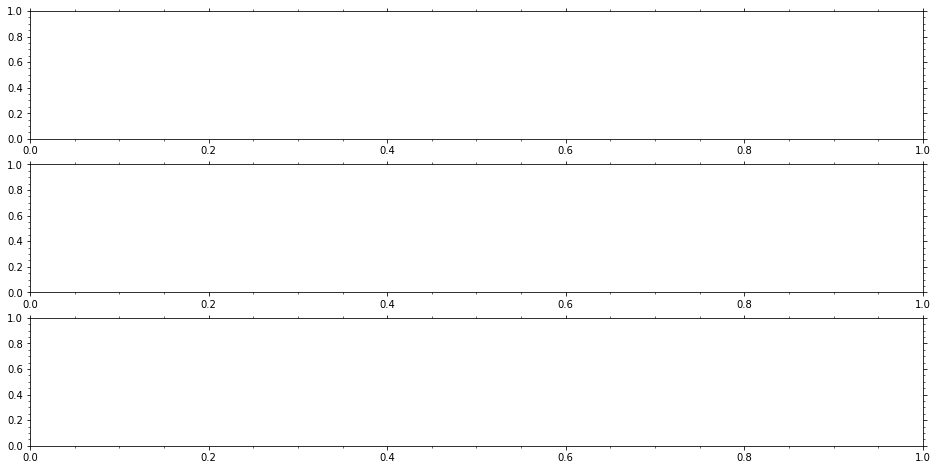

In [31]:
fig1, axs = plt.subplots(3,1,figsize=(16,8))

ii = 7000

axs[0].scatter(t_set_plt,noise,s=5)
axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
axs2 = axs[0].twinx()
axs2.plot(t_set_plt,dec,color='k')
axs[0].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(raster1_start_mjd,raster1_stop_mjd)
axs2.set_ylim(5,65)
axs2.set_ylabel('dec.')

axs[1].scatter(t_set_plt,noise,s=5)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
axs2 = axs[1].twinx()
axs2.scatter(t_set_plt,az,color='k',s=0.01)
axs[1].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
axs2.set_ylim(-20,380)
axs2.set_ylabel('az.')

axs[2].scatter(t_set_plt,noise,s=5)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
axs2 = axs[2].twinx()
axs2.plot(t_set_plt,dec,color='k')
axs[2].scatter(t_noise,LL_dnoise_arr[:,ii]/np.nanmean(LL_dnoise_arr[:,ii]),s=10,c='red')
#axs2.set_xlim(raster1_start_mjd,raster1_stop_mjd)
axs2.set_ylim(5,65)
axs2.set_ylabel('dec.')

for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_ylim(-0.1,1.2)
    axs[i].set_ylabel('noise (arbitrary units)')
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_firing_phase'+phase+'_day'+day+'.png')

## Check noise deflection vs frequency for sample noise source instance

In [ ]:
fig1, axs = plt.subplots(2,1,figsize=(16,8))

t_noise_idx = 100

axs[0].scatter(freq,10*np.log10(LL_dnoise_arr[t_noise_idx,:]),s=1,label='LL')
axs[0].scatter(freq,10*np.log10(RR_dnoise_arr[t_noise_idx,:]),s=1,label='RR')
axs[0].scatter(freq,10*np.log10(np.sqrt((reRL_dnoise_arr[t_noise_idx,:])**2 + 
                                        (imRL_dnoise_arr[t_noise_idx,:])**2)),s=1,label='PI')
axs[0].grid()
axs[0].set_ylim(55,75)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Power deflection (dB)')
axs[0].legend(markerscale=10)

axs[1].scatter(freq,reRL_dnoise_arr[t_noise_idx,:],s=1,label='reRL')
axs[1].scatter(freq,imRL_dnoise_arr[t_noise_idx,:],s=1,label='imRL')
axs[1].grid()
axs[1].set_ylim(-2e7,2e7)
axs[1].set_xlim(350,1030)
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Power deflection (spectrometer units)')
axs[1].legend(markerscale=10)

plt.tight_layout()
#plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_power_deflection_vs_freq_phase'+phase+'_day'+day+'.png')

## Remove outliers in noise deflection

In [ ]:
%%time
LL_dnoise_fix = LL_dnoise_arr.copy()
RR_dnoise_fix = RR_dnoise_arr.copy()
reRL_dnoise_fix = reRL_dnoise_arr.copy()
imRL_dnoise_fix = imRL_dnoise_arr.copy()
std_mult = 1.0
for i in range(0,len(freq)):
    
    print(i,freq[i])    
    for j in range(0,len(t_noise)):
        
        window = 10
        if ((j >= window) & (j < len(t_noise)-window)):
            LL_near = np.nanmedian(LL_dnoise_arr[j-window:j+window,i])
            RR_near = np.nanmedian(RR_dnoise_arr[j-window:j+window,i])
        else:
            if j < window:
                LL_near = np.nanmedian(LL_dnoise_arr[0:j+window,i])
                RR_near = np.nanmedian(RR_dnoise_arr[0:j+window,i])
            if j >= len(t_noise)-window:
                LL_near = np.nanmedian(LL_dnoise_arr[j-window:-1,i])
                RR_near = np.nanmedian(RR_dnoise_arr[j-window:-1,i])
        
        if ( LL_dnoise_arr[j,i] > 1.1*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( LL_dnoise_arr[j,i] < 0.9*LL_near):
            LL_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
            
        if ( RR_dnoise_arr[j,i] > 1.1*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan
        if ( RR_dnoise_arr[j,i] < 0.9*RR_near):
            RR_dnoise_fix[j,i] = np.nan
            reRL_dnoise_fix[j,i] = np.nan
            imRL_dnoise_fix[j,i] = np.nan


## Calculate fits to noise deflection vs time

In [ ]:
%%time
LL_fit = np.empty_like(LL)
RR_fit = np.empty_like(RR)
reRL_fit = np.empty_like(reRL)
imRL_fit = np.empty_like(imRL)

LL_fit_noise_pt = np.empty_like(LL_dnoise_arr)
RR_fit_noise_pt = np.empty_like(RR_dnoise_arr)
reRL_fit_noise_pt = np.empty_like(reRL_dnoise_arr)
imRL_fit_noise_pt = np.empty_like(imRL_dnoise_arr)

for i in range(0,len(freq)):
    print(freq[i])
    try:
        wuse = np.where(np.isfinite(LL_dnoise_fix[:,i]))[0]
        pL = np.polyfit(np.array(t_noise)[wuse]-t_mean,LL_dnoise_fix[wuse,i],9)
        LL_fit[:,i] = np.polyval(pL, t_set_plt-t_mean)
        LL_fit_noise_pt[:,i] = np.polyval(pL, t_noise-t_mean)

        wuse = np.where(np.isfinite(RR_dnoise_fix[:,i]))[0]
        pR = np.polyfit(np.array(t_noise)[wuse]-t_mean,RR_dnoise_fix[wuse,i],9)
        RR_fit[:,i] = np.polyval(pR, t_set_plt-t_mean)
        RR_fit_noise_pt[:,i] = np.polyval(pR, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(reRL_dnoise_fix[:,i]))[0]
        pre = np.polyfit(np.array(t_noise)[wuse]-t_mean,reRL_dnoise_fix[wuse,i],9)
        reRL_fit[:,i] = np.polyval(pre, t_set_plt-t_mean)
        reRL_fit_noise_pt[:,i] = np.polyval(pre, t_noise-t_mean)
    
        wuse = np.where(np.isfinite(imRL_dnoise_fix[:,i]))[0]
        pim = np.polyfit(np.array(t_noise)[wuse]-t_mean,imRL_dnoise_fix[wuse,i],9)
        imRL_fit[:,i] = np.polyval(pim, t_set_plt-t_mean)
        imRL_fit_noise_pt[:,i] = np.polyval(pim, t_noise-t_mean)
    except:
        pass
        


## Read in persistent RFI mask

In [ ]:
i = 0
RFI_mask_idx = []
with open('/srv/data/dva/RFIpersist_mask/RFIpersist_mask.txt') as fp:
    for line in fp:
        if i>0: 
            #print(line)
            RFI_mask_idx.append(int(line.split()[0]))
        i=i+1

## Plot power and gain for a single frequency

In [ ]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,10*np.log10(RR_dnoise_arr[:,wf]),s=20,color='red')
axs[0].scatter(t_noise,10*np.log10(RR_dnoise_fix[:,wf]),s=20,color='C1',label='RR',zorder=10)
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=20,color='blue')
axs[0].scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=20,color='C0',label='LL',zorder=10)
axs[0].plot(t_set_plt,10*np.log10(LL_fit[:,wf]),color='blue',linewidth=2,zorder=0)
axs[0].plot(t_set_plt,10*np.log10(RR_fit[:,wf]),color='red',linewidth=2,zorder=0)
axs[0].set_ylim(65,69)
axs[0].set_ylabel('Noise source deflection (dB)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-5,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(RR_dnoise_fix[:,wf]-RR_fit_noise_pt[:,wf])/RR_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(LL_dnoise_fix[:,wf]-LL_fit_noise_pt[:,wf])/LL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(raster1_start_mjd[0],raster2_stop_mjd[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_deflection_fits_800MHz_phase'+phase+'_day'+day+'.png')

In [ ]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(3,1,figsize=(16,12))

axs[0].scatter(t_noise,imRL_dnoise_arr[:,wf],s=20,color='red')
axs[0].scatter(t_noise,imRL_dnoise_fix[:,wf],s=20,color='C1',label='imRL',zorder=10)
axs[0].scatter(t_noise,reRL_dnoise_arr[:,wf],s=20,color='blue')
axs[0].scatter(t_noise,reRL_dnoise_fix[:,wf],s=20,color='C0',label='reRL',zorder=10)
axs[0].plot(t_set_plt,reRL_fit[:,wf],color='blue',linewidth=2,zorder=0)
axs[0].plot(t_set_plt,imRL_fit[:,wf],color='red',linewidth=2,zorder=0)
#axs[0].set_ylim(65,69)
axs[0].set_ylabel('Noise source deflection (raw spectrometer units)')
axs[0].legend(markerscale=2)

ax2 = axs[0].twinx()
ax2.plot(t_weath_plt,temp_C,color='purple',linewidth=2)
ax2.set_ylim(-5,35)
ax2.set_ylabel('Outside Temperature')

axs[1].scatter(t_noise,(imRL_dnoise_fix[:,wf]-imRL_fit_noise_pt[:,wf])/imRL_dnoise_fix[:,wf],
               color='C1',zorder=10)
axs[1].set_ylim(-0.15,0.15)
axs[1].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[1].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[1].set_ylabel('Fractional residuals')

axs[2].scatter(t_noise,(reRL_dnoise_fix[:,wf]-reRL_fit_noise_pt[:,wf])/reRL_dnoise_fix[:,wf],
               color='C0',zorder=10)
axs[2].set_ylim(-0.15,0.15)
axs[2].fill_between(t_set_plt,-0.05,0.05,zorder=0,color='grey',alpha=0.4)
axs[2].fill_between(t_set_plt,-0.01,0.01,zorder=1,color='grey',alpha=0.4)
axs[2].set_ylabel('Fractional residuals')


for i in range(0,3):
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlim(raster1_start_mjd[0],raster2_stop_mjd[-1])
    axs[i].grid()
axs[2].set_xlabel('UTC')
    
plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/noise_deflection_pol_fits_800MHz_phase'+phase+'_day'+day+'.png')

In [ ]:
fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])


lims_raw1 = [65,65,65]
lims_raw2 = [75,75,75]
lims_cor1 = [2,2,2]
lims_cor2 = [8,8,8]

sz=1
fig1, axs = plt.subplots(3,1,figsize=(20,12))

for i in range(0,3):
    axs[i].scatter(t_set_plt,10*np.log10(LL[:,wf]),s=sz)
    axs[i].set_ylim(lims_raw1[i],lims_raw2[i])
        
    ax2 = axs[i].twinx()
    ax2.scatter(t_set_plt,LL[:,wf]/LL_fit[:,wf],s=sz,color='red')
    ax2.set_ylim(lims_cor1[i],lims_cor2[i])
    ax2.set_ylabel('Corrected power (noise src units; red)')
    
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].grid()
    axs[i].set_ylabel('Raw power (dB; blue)')

axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
#axs[0].set_xlim(raster1_start_mjd,raster1_start_mjd+0.005)
#axs[0].set_ylim(2e7,4e7)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
#axs[1].set_ylim(1e7,10e7)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
#axs[2].set_ylim(1e7,10e7)

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_LL_800MHz_phase'+phase+'_day'+day+'.png')

## Checking frequency dependence

In [ ]:
fig1, axs = plt.subplots(2,1,figsize=(16,12))

t_idx = 20000
print(t[t_idx])
s = 0.5

axs[0].scatter(freq,10*np.log10(LL[t_idx,:]),s=s,color='C0',label='LL')
axs[0].scatter(freq,10*np.log10(RR[t_idx,:]),s=s,color='C1',label='RR')
ax2 = axs[0].twinx()
ax2.scatter(freq,10*np.log10(np.sqrt((reRL[t_idx,:])**2+(imRL[t_idx])**2)),s=s,color='C2',label='PI')
axs[0].grid()
axs[0].set_ylim(65,80)
ax2.set_ylim(20,80)
axs[0].set_xlim(350,1030)
axs[0].set_ylabel('Raw power (dB)')
axs[0].legend(markerscale=10,loc='upper right')
ax2.legend(markerscale=10,loc='lower right')

axs[1].scatter(freq,LL[t_idx,:]/LL_fit[t_idx,:],s=s,color='blue',label='LL')
axs[1].scatter(freq,RR[t_idx,:]/RR_fit[t_idx,:],s=s,color='red',label='RR')
ax2 = axs[1].twinx()
ax2.scatter(freq,np.sqrt((reRL[t_idx,:]/reRL_fit[t_idx,:])**2+(imRL[t_idx]/imRL_fit[t_idx])**2),s=s,color='green',label='PI')
ax2.set_ylim(-1,2)
axs[1].set_ylim(0,10)
axs[1].grid()
axs[1].set_xlim(350,1030)
axs[1].set_ylabel('Corrected power (noise source units)')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend(markerscale=10,loc='upper right')
ax2.legend(markerscale=10,loc='lower right')

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_spectrum_phase'+phase+'_day'+day+'.png')

## Write out gain-corrected files

In [ ]:
def write_gain_corrected(file,RR_out,LL_out,reRL_out,imRL_out,infiles,outfiles,inname,outname,GR,GL,GreRL,GimRL):

    cmd2 = 'cp '+infiles+inname+' '+outfiles+outname+'.h5'
    print(cmd2)
    os.system(cmd2)
    print('got here')
    file_new = h5py.File(outfiles+outname+'.h5','r+')
    
    print(inname)
    print(RR_out.shape)
    print(GR.shape)
    print(file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:].shape)
    print('')
    
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,0,:] = RR_out/GR
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,1,:] = LL_out/GL
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,2,:] = reRL_out/GreRL
    file_new['data']['beam_0']['band_SB0']['scan_0']['data'][:,3,:] = imRL_out/GimRL
           
    file_new.close()

    
# Raster scan 1:
for i in range(0,Ne):   
    if Ne == 1:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster1_gain_corr'
    else:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'_gain_corr'
        
    file = h5py.File(dir_in_rast+inname,'r')

    write_gain_corrected(file,RR[idx1_rast1[i]:idx2_rast1[i],:],
                              LL[idx1_rast1[i]:idx2_rast1[i],:],
                            reRL[idx1_rast1[i]:idx2_rast1[i],:],
                            imRL[idx1_rast1[i]:idx2_rast1[i],:],
                         dir_in_rast,dir_out_rast,inname,outname,
                         RR_fit[idx1_rast1[i]:idx2_rast1[i],:],
                         LL_fit[idx1_rast1[i]:idx2_rast1[i],:],
                       reRL_fit[idx1_rast1[i]:idx2_rast1[i],:],
                       imRL_fit[idx1_rast1[i]:idx2_rast1[i],:])

# Raster scan 2:
for i in range(0,Nm):   
    if Nm == 1:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster2_gain_corr'
    else:
        inname  = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'.h5'
        outname = 'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'_gain_corr'
        
    file = h5py.File(dir_in_rast+inname,'r')

    write_gain_corrected(file,RR[idx1_rast2[i]:idx2_rast2[i],:],
                              LL[idx1_rast2[i]:idx2_rast2[i],:],
                            reRL[idx1_rast2[i]:idx2_rast2[i],:],
                            imRL[idx1_rast2[i]:idx2_rast2[i],:],
                         dir_in_rast,dir_out_rast,inname,outname,
                         RR_fit[idx1_rast2[i]:idx2_rast2[i],:],
                         LL_fit[idx1_rast2[i]:idx2_rast2[i],:],
                       reRL_fit[idx1_rast2[i]:idx2_rast2[i],:],
                       imRL_fit[idx1_rast2[i]:idx2_rast2[i],:])



#file = h5py.File(dir_in_rast+inname,'r')
#w = np.where((t_set_plt >= rast2_file_t[0]) & (t_set_plt <= rast2_file_t[-1]))[0]
#write_gain_corrected(file,RR[w,:],LL[w,:],reRL[w,:],imRL[w,:],dir_in_rast,dir_out_rast,inname,outname,
#                     GL_fit[w],GR_fit[w])

In [ ]:
for i in scan_id:
    inname  = 'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'.h5'
    outname = 'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'_gain_corr'
    file = h5py.File(dir_in_az+inname,'r')
    print(i,file)
    t_az = Time(file['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][:],
                        format='isot',scale='utc').mjd
    w = np.where((t_set_plt >= t_az[0]) & (t_set_plt <= t_az[-1]))[0]
    print(w.shape)
    print('')
    write_gain_corrected(file,RR[w,:],LL[w,:],reRL[w,:],imRL[w,:],
                         dir_in_az,dir_out_az,inname,outname,
                         RR_fit[w,:],LL_fit[w,:],reRL_fit[w,:],imRL_fit[w,:])

In [ ]:
del RR
del reRL
del imRL
del RR_fit
del reRL_fit
del imRL_fit

gc.collect()

## Waterfall plot for power, gain and temperature:

In [ ]:
%%time

#Gmin = 0.9
#Gmax = 1.1
noisemin = 55
noisemax = 75
dBmin = 65
dBmax = 75

fplot = 800
df = freq[1]-freq[0]
wf = np.where(abs(freq-fplot)<df/2)[0][0]
print(freq[wf])

fig1, axs = plt.subplots(4,1,figsize=(20,25),sharex=True,gridspec_kw={'height_ratios': [1,0.5,1,1]},
                         constrained_layout=True)
fs = 16

data1 = LL.T
data2 = LL_fit.T
data1[RFI_mask_idx,:] = np.nan
data2[RFI_mask_idx,:] = np.nan


for i in range(0,len(scan_id)):
    w = np.where((t_set_plt>=scan_start_mjd[i]) & (t_set_plt<=scan_stop_mjd[i]))[0]
    extent = [scan_start_mjd[i],scan_stop_mjd[i],freq[0],freq[-1]]
    
    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                        extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                        extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')


for i in range(0,Ne):
    w = np.where((t_set_plt>=raster1_start_mjd[i]) & (t_set_plt<=raster1_stop_mjd[i]))[0]
    extent = [raster1_start_mjd[i],raster1_stop_mjd[i],freq[0],freq[-1]]

    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                        extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                        extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')

for i in range(0,Nm):
    w = np.where((t_set_plt>=raster2_start_mjd[i]) & (t_set_plt<=raster2_stop_mjd[i]))[0]
    extent = [raster2_start_mjd[i],raster2_stop_mjd[i],freq[0],freq[-1]]

    im2 = axs[2].imshow(10*np.log10(data1[:,w]),aspect='auto',vmin=dBmin,vmax=dBmax,origin='lower',
                         extent=extent,cmap='viridis')    
    im0 = axs[0].imshow(10*np.log10(data2[:,w]),aspect='auto',vmin=noisemin,vmax=noisemax,origin='lower',
                         extent=extent,cmap='viridis')
    im3 = axs[3].imshow(data1[:,w]/data2[:,w],aspect='auto',vmin=1,vmax=8,origin='lower',
                        extent=extent,cmap='viridis')

cbar0= fig1.colorbar(im0,ax=axs[0])
cbar0.ax.tick_params(labelsize=fs) 
cbar0.set_label('Fitted noise source LL Power deflection (dB)', fontsize=fs)

cbar2= fig1.colorbar(im2,ax=axs[2])
cbar2.ax.tick_params(labelsize=fs) 
cbar2.set_label('LL Power (dB)', fontsize=fs)

cbar3= fig1.colorbar(im3,ax=axs[3])
cbar3.ax.tick_params(labelsize=fs) 
cbar3.set_label('LL Power (noise units)', fontsize=fs)

axs[1].plot(t_weath_plt,temp_C,color='purple',linewidth=3)
axs[1].set_ylim(-5,35)     
axs[1].set_ylabel('Temperature (C)',fontsize=fs)
axs[1].axvspan(raster1_start_mjd[0],raster1_stop_mjd[-1],color='C0',alpha=0.1)
axs[1].axvspan(raster2_start_mjd[0],raster2_stop_mjd[-1],color='C0',alpha=0.1)
ax2 = axs[1].twinx()
ax2.scatter(t_noise,10*np.log10(LL_dnoise_arr[:,wf]),s=10,color='red')
ax2.scatter(t_noise,10*np.log10(LL_dnoise_fix[:,wf]),s=10,color='k')
ax2.set_ylim(noisemin,noisemax)
ax2.set_ylabel('Noise source power (LL) at 800 MHz',fontsize=fs)
ax2.tick_params(axis='y', labelsize=fs)
for i in range(0,len(scan_id)):
    elhere = el[abs(t_set_plt-scan_start_mjd[i])<1e-4][0]
    if abs(elhere-49.32)<0.5:
        clr = 'C1'
    elif abs(elhere-20.0)<0.5:
        clr = 'C2'
    axs[1].axvspan(scan_start_mjd[i],scan_stop_mjd[i],color=clr,alpha=0.1)
axs[1].grid() 

for i in range(0,4):
    axs[i].set_xlim(t_set_plt[0],t_set_plt[-1])
    axs[i].tick_params(axis='both', labelsize=fs,labelbottom=True)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].set_xlabel('Time (UTC)',fontsize=fs)
    if i != 1:
        axs[i].set_ylim(freq[0],freq[-1])
        axs[i].set_ylabel('Frequency (MHz)',fontsize=fs)
    
#plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/waterfall_phase'+phase+'_day'+day+'.png')

In [ ]:
del LL
del LL_fit

gc.collect()

## Test new file by comparing to old file:

In [ ]:
t_test = []
az_test = []
dec_test = []
ra_test = []
el_test = []
noise_test = []

# Use one of the scans to get the list of frequencies:
scan0 = f"{scan_id[0]:04}"
file_test = h5py.File(dir_out_az+'dva_survey_phase'+phase+'_raw_'+scan0+'_gain_corr.h5','r')
freq_test = file_test['data']['beam_0']['band_SB0']['frequency'][:]/1e6

# Create empty arrays for the power data:
RR_test = np.empty([0,len(freq_test)])
LL_test = np.empty([0,len(freq_test)])
reRL_test = np.empty([0,len(freq_test)])
imRL_test = np.empty([0,len(freq_test)])

# Raster scan 1:
for i in range(0,Ne):
    if Ne == 1:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+'_gain_corr.h5','r')
    else:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster1'+rast_list[i]+'_gain_corr.h5','r')

    rast1_file_t_test = [Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                            format='isot',scale='utc').mjd,
                        Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                            format='isot',scale='utc').mjd]
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)


# Loop through all the scans in the "scan_num" list:
for i in scan_id:
    file_test = h5py.File(dir_out_az+'dva_survey_phase'+phase+'_raw_'+f"{i:04}"+'_gain_corr.h5','r')
    print(i,file_test)
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)

# Raster scan 2:
for i in range(0,Nm):
    if Nm == 1:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+'_gain_corr.h5','r')
    else:
        file_test = h5py.File(dir_out_rast+'dva_survey_phase'+phase+'_day0'+day+'_raster2'+rast_list[i]+'_gain_corr.h5','r')

    rast2_file_t_test = [Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][0],
                            format='isot',scale='utc').mjd,
                        Time(file_test['data']['beam_0']['band_SB0']['scan_0']['metadata']['utc'][-1],
                            format='isot',scale='utc').mjd]
    RR_test,LL_test,reRL_test,imRL_test,dec_test,ra_test,el_test,az_test,t_test,noise_test,idx1_test,idx2_test = concatenate_data(file_test,RR_test,LL_test,reRL_test,imRL_test,
                                                            dec_test,ra_test,el_test,az_test,t_test,noise_test)


t_test_plt = Time(t_test, format='isot',scale='utc').mjd


In [ ]:
fplot = 800
df = freq_test[1]-freq_test[0]
wf = np.where(abs(freq_test-fplot)<df/2)[0][0]
print(freq_test[wf])

lims_raw1 = [65,65,65]
lims_raw2 = [75,75,75]
lims_cor1 = [2,2,2]
lims_cor2 = [8,8,8]

sz=1
fig1, axs = plt.subplots(3,1,figsize=(20,12))

for i in range(0,3):
    axs[i].scatter(t_test_plt,LL_test[:,wf],s=sz,color='red',alpha=0)
    axs[i].set_ylim(lims_raw1[i],lims_raw2[i])
        
    ax2 = axs[i].twinx()
    ax2.scatter(t_test_plt,LL_test[:,wf],s=sz,color='red')
    ax2.set_ylim(lims_cor1[i],lims_cor2[i])
    axs[i].set_ylabel('Raw power (dB) - not plotted')
    
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    axs[i].fmt_xdata = mdates.DateFormatter('%H:%M:%S')
    axs[i].grid()
    ax2.set_ylabel('Corrected power (noise src units)')

axs[0].set_xlim(raster1_start_mjd[0],raster1_stop_mjd[-1])
#axs[0].set_xlim(raster1_start_mjd,raster1_start_mjd+0.005)
#axs[0].set_ylim(2e7,4e7)
axs[1].set_xlim(scan_start_mjd[0],scan_stop_mjd[-1])
#axs[1].set_ylim(1e7,10e7)
axs[2].set_xlim(raster2_start_mjd[0],raster2_stop_mjd[-1])
#axs[2].set_ylim(1e7,10e7)

plt.tight_layout()
plt.savefig('../DVA_PLOTS/noise_gain_corr/correction_example_LL_800MHz_phase'+phase+'_day'+day+'_test.png')

In [ ]:
beam_width = []
freq_beam = []

with open('../DATA/beam_widths.txt') as fp:
    for line in fp:
        #print(line.split()[0],line.split()[1])
        beam_width.append(float(line.split()[1]))
        freq_beam.append(float(line.split()[0]))


In [ ]:
print(LL_dnoise_arr.shape)
print(len(t_noise))
print(LL_fit_noise_pt.shape)

ii = 30

#print(LL_dnoise_arr[0,:]/LL_fit_noise_pt[0,:])

fig1, axs = plt.subplots(1,1,figsize=(20,12))

axs.scatter(freq,LL_dnoise_arr[ii,:],s=5)
axs.scatter(freq,LL[20000,:],s=5)
ax2 = axs.twinx()
ax2.scatter(freq_beam,beam_width,s=5,color='C2')
axs.set_ylim(0,5e7)
ax2.set_ylim(0.5,1.8)
axs.set_xlim(350,700)

In [ ]:
fig1, axs = plt.subplots(1,1,figsize=(20,12))

i1 = 30
print(t_noise[i1])
i2 = 30000
print(t_set_plt[i2])

axs.scatter(freq,LL_fit[i2,:],s=5)
ax2 = axs.twinx()
axs.scatter(freq,LL[i2,:],s=5,color='C2')

ax2.scatter(freq,LL[i2,:]/LL_fit[i2,:],color='C3',s=5)
ax2.scatter(freq_beam,5.0*np.array(beam_width)-3.0,s=5,color='C4')

axs.set_ylim(0,4e7)
ax2.set_ylim(0,5)
axs.set_xlim(350,500)
axs.axvline(447.5)
axs.axvline(420)